# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_cores-metehan",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 19,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                16,
                17,
                18,
            ],
            "domains": [0, 1, 2],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/metehan.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Metehan_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'CORES_5', 'CORES_2', 'CORES_3', 'CORES_4', 'CORES_1'}


{'Metehan_1', 'Metehan_0', 'Metehan_2'}


tensor([[[ 0.0766,  0.1315,  0.0709,  ...,  0.1722, -0.1523, -0.6660],
         [ 0.0407,  0.0568,  0.3538,  ..., -0.3084, -0.8542, -0.4635]],

        [[-0.1666, -0.3740,  0.2604,  ..., -0.1780, -0.8332,  0.7092],
         [ 0.3143, -0.3077, -0.8181,  ..., -0.7982,  0.0350, -0.4308]],

        [[-0.3009, -0.3363,  0.4022,  ..., -0.8062, -0.2474,  0.9467],
         [ 0.2961, -0.7833, -0.3496,  ..., -0.1853,  0.0755, -1.2447]],

        ...,

        [[-0.3509,  0.2991,  0.8102,  ...,  0.5205,  0.7419, -0.0306],
         [-0.2968,  0.1460,  0.0565,  ...,  0.2355, -1.0622, -0.1036]],

        [[ 0.4316,  0.0395, -0.3108,  ...,  0.3502,  1.1296,  0.2836],
         [-0.0296,  0.4810,  0.2639,  ...,  0.8855,  0.8041, -0.5377]],

        [[ 0.1666,  0.4877, -0.1544,  ..., -0.5171,  0.2377,  0.9729],
         [-0.0711,  0.1078,  0.4926,  ...,  0.2475,  0.9778,  0.9999]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 612], examples_per_second: 407.6014, train_label_loss: 2.8570, 


epoch: 1, [batch: 62 / 612], examples_per_second: 3232.3418, train_label_loss: 0.0846, 


epoch: 1, [batch: 123 / 612], examples_per_second: 2938.9226, train_label_loss: 0.1476, 


epoch: 1, [batch: 184 / 612], examples_per_second: 2954.3384, train_label_loss: 0.1023, 


epoch: 1, [batch: 245 / 612], examples_per_second: 2972.5319, train_label_loss: 0.0553, 


epoch: 1, [batch: 306 / 612], examples_per_second: 2952.6864, train_label_loss: 0.0202, 


epoch: 1, [batch: 367 / 612], examples_per_second: 2939.2182, train_label_loss: 0.0975, 


epoch: 1, [batch: 428 / 612], examples_per_second: 2971.8842, train_label_loss: 0.0615, 


epoch: 1, [batch: 489 / 612], examples_per_second: 2990.3124, train_label_loss: 0.0756, 


epoch: 1, [batch: 550 / 612], examples_per_second: 2974.8118, train_label_loss: 0.0558, 


epoch: 1, source_val_acc_label: 0.9929, target_val_acc_label: 0.2924, source_val_label_loss: 0.0258, target_val_label_loss: 2.7103, 


New best


epoch: 2, [batch: 1 / 615], examples_per_second: 52.9736, train_label_loss: 0.0176, 


epoch: 2, [batch: 62 / 615], examples_per_second: 2975.4612, train_label_loss: 0.0003, 


epoch: 2, [batch: 123 / 615], examples_per_second: 2950.2002, train_label_loss: 0.0004, 


epoch: 2, [batch: 185 / 615], examples_per_second: 2977.4055, train_label_loss: 0.0485, 


epoch: 2, [batch: 246 / 615], examples_per_second: 2975.8444, train_label_loss: 0.1431, 


epoch: 2, [batch: 308 / 615], examples_per_second: 2961.5607, train_label_loss: 0.1787, 


epoch: 2, [batch: 369 / 615], examples_per_second: 2954.6188, train_label_loss: 0.0018, 


epoch: 2, [batch: 430 / 615], examples_per_second: 2932.0137, train_label_loss: 0.0433, 


epoch: 2, [batch: 492 / 615], examples_per_second: 2966.6239, train_label_loss: 0.0003, 


epoch: 2, [batch: 553 / 615], examples_per_second: 2975.8633, train_label_loss: 0.0003, 


epoch: 2, source_val_acc_label: 0.9849, target_val_acc_label: 0.2398, source_val_label_loss: 0.0521, target_val_label_loss: 2.6035, 


New best


epoch: 3, [batch: 1 / 614], examples_per_second: 52.9585, train_label_loss: 0.0508, 


epoch: 3, [batch: 62 / 614], examples_per_second: 2999.3955, train_label_loss: 0.0005, 


epoch: 3, [batch: 123 / 614], examples_per_second: 3010.8443, train_label_loss: 0.0216, 


epoch: 3, [batch: 184 / 614], examples_per_second: 2971.3509, train_label_loss: 0.0000, 


epoch: 3, [batch: 246 / 614], examples_per_second: 2989.4920, train_label_loss: 0.0344, 


epoch: 3, [batch: 307 / 614], examples_per_second: 2973.3944, train_label_loss: 0.0003, 


epoch: 3, [batch: 368 / 614], examples_per_second: 2979.3962, train_label_loss: 0.0026, 


epoch: 3, [batch: 430 / 614], examples_per_second: 2897.7567, train_label_loss: 0.0004, 


epoch: 3, [batch: 491 / 614], examples_per_second: 2962.6174, train_label_loss: 0.0932, 


epoch: 3, [batch: 552 / 614], examples_per_second: 2980.5906, train_label_loss: 0.2498, 


epoch: 3, source_val_acc_label: 0.9920, target_val_acc_label: 0.2251, source_val_label_loss: 0.0299, target_val_label_loss: 2.5280, 


New best


epoch: 4, [batch: 1 / 615], examples_per_second: 52.5172, train_label_loss: 0.0021, 


epoch: 4, [batch: 62 / 615], examples_per_second: 2977.5031, train_label_loss: 0.0000, 


epoch: 4, [batch: 123 / 615], examples_per_second: 2994.9318, train_label_loss: 0.0095, 


epoch: 4, [batch: 185 / 615], examples_per_second: 3016.7796, train_label_loss: 0.0762, 


epoch: 4, [batch: 246 / 615], examples_per_second: 2997.7871, train_label_loss: 0.0012, 


epoch: 4, [batch: 308 / 615], examples_per_second: 3021.9334, train_label_loss: 0.0000, 


epoch: 4, [batch: 369 / 615], examples_per_second: 3020.4100, train_label_loss: 0.0278, 


epoch: 4, [batch: 430 / 615], examples_per_second: 3008.0932, train_label_loss: 0.0317, 


epoch: 4, [batch: 492 / 615], examples_per_second: 2980.5163, train_label_loss: 0.0006, 


epoch: 4, [batch: 553 / 615], examples_per_second: 3003.3222, train_label_loss: 0.0006, 


epoch: 4, source_val_acc_label: 0.9926, target_val_acc_label: 0.2281, source_val_label_loss: 0.0255, target_val_label_loss: 2.4518, 


New best


epoch: 5, [batch: 1 / 613], examples_per_second: 53.3123, train_label_loss: 0.0000, 


epoch: 5, [batch: 62 / 613], examples_per_second: 2963.3156, train_label_loss: 0.0000, 


epoch: 5, [batch: 123 / 613], examples_per_second: 2975.7821, train_label_loss: 0.0000, 


epoch: 5, [batch: 184 / 613], examples_per_second: 2965.1206, train_label_loss: 0.0253, 


epoch: 5, [batch: 245 / 613], examples_per_second: 2948.3687, train_label_loss: 0.0000, 


epoch: 5, [batch: 307 / 613], examples_per_second: 2958.4156, train_label_loss: 0.2888, 


epoch: 5, [batch: 368 / 613], examples_per_second: 2980.2072, train_label_loss: 0.0001, 


epoch: 5, [batch: 429 / 613], examples_per_second: 2950.7106, train_label_loss: 0.0000, 


epoch: 5, [batch: 490 / 613], examples_per_second: 2972.2680, train_label_loss: 0.1343, 


epoch: 5, [batch: 551 / 613], examples_per_second: 2971.8500, train_label_loss: 0.0001, 


epoch: 5, source_val_acc_label: 0.9939, target_val_acc_label: 0.2325, source_val_label_loss: 0.0314, target_val_label_loss: 2.4214, 


New best


epoch: 6, [batch: 1 / 616], examples_per_second: 52.6968, train_label_loss: 0.0189, 


epoch: 6, [batch: 62 / 616], examples_per_second: 2999.5399, train_label_loss: 0.0002, 


epoch: 6, [batch: 124 / 616], examples_per_second: 3015.0985, train_label_loss: 0.0000, 


epoch: 6, [batch: 185 / 616], examples_per_second: 3012.3174, train_label_loss: 0.0000, 


epoch: 6, [batch: 247 / 616], examples_per_second: 2984.6992, train_label_loss: 0.0000, 


epoch: 6, [batch: 308 / 616], examples_per_second: 2997.5405, train_label_loss: 0.0005, 


epoch: 6, [batch: 370 / 616], examples_per_second: 3011.3207, train_label_loss: 0.0000, 


epoch: 6, [batch: 431 / 616], examples_per_second: 3003.9127, train_label_loss: 0.1773, 


epoch: 6, [batch: 493 / 616], examples_per_second: 2994.1874, train_label_loss: 0.0000, 


epoch: 6, [batch: 554 / 616], examples_per_second: 2965.8036, train_label_loss: 0.1186, 


epoch: 6, source_val_acc_label: 0.9955, target_val_acc_label: 0.2909, source_val_label_loss: 0.0175, target_val_label_loss: 2.1290, 


New best


epoch: 7, [batch: 1 / 614], examples_per_second: 52.9439, train_label_loss: 0.0000, 


epoch: 7, [batch: 62 / 614], examples_per_second: 2977.5508, train_label_loss: 0.7542, 


epoch: 7, [batch: 123 / 614], examples_per_second: 3010.1537, train_label_loss: 0.1488, 


epoch: 7, [batch: 184 / 614], examples_per_second: 2998.5234, train_label_loss: 0.0038, 


epoch: 7, [batch: 246 / 614], examples_per_second: 2997.5367, train_label_loss: 0.0014, 


epoch: 7, [batch: 307 / 614], examples_per_second: 3022.9581, train_label_loss: 0.0000, 


epoch: 7, [batch: 368 / 614], examples_per_second: 3000.9027, train_label_loss: 0.0000, 


epoch: 7, [batch: 430 / 614], examples_per_second: 2983.1051, train_label_loss: 0.0000, 


epoch: 7, [batch: 491 / 614], examples_per_second: 2988.5384, train_label_loss: 0.0000, 


epoch: 7, [batch: 552 / 614], examples_per_second: 2972.6216, train_label_loss: 0.0000, 


epoch: 7, source_val_acc_label: 0.9942, target_val_acc_label: 0.2558, source_val_label_loss: 0.0239, target_val_label_loss: 2.2216, 


epoch: 8, [batch: 1 / 612], examples_per_second: 53.2544, train_label_loss: 0.0000, 


epoch: 8, [batch: 62 / 612], examples_per_second: 2968.8328, train_label_loss: 0.0001, 


epoch: 8, [batch: 123 / 612], examples_per_second: 2961.9506, train_label_loss: 0.0012, 


epoch: 8, [batch: 184 / 612], examples_per_second: 2994.1341, train_label_loss: 0.0000, 


epoch: 8, [batch: 245 / 612], examples_per_second: 2978.5338, train_label_loss: 0.0002, 


epoch: 8, [batch: 306 / 612], examples_per_second: 2979.2845, train_label_loss: 0.0010, 


epoch: 8, [batch: 367 / 612], examples_per_second: 2967.6540, train_label_loss: 0.0000, 


epoch: 8, [batch: 428 / 612], examples_per_second: 2976.3957, train_label_loss: 0.0000, 


epoch: 8, [batch: 489 / 612], examples_per_second: 2992.1172, train_label_loss: 0.0000, 


epoch: 8, [batch: 550 / 612], examples_per_second: 2967.4265, train_label_loss: 0.0002, 


epoch: 8, source_val_acc_label: 0.9910, target_val_acc_label: 0.2573, source_val_label_loss: 0.0644, target_val_label_loss: 2.1530, 


epoch: 9, [batch: 1 / 615], examples_per_second: 53.7818, train_label_loss: 0.1212, 


epoch: 9, [batch: 62 / 615], examples_per_second: 3002.9571, train_label_loss: 0.0000, 


epoch: 9, [batch: 123 / 615], examples_per_second: 2967.5953, train_label_loss: 0.0000, 


epoch: 9, [batch: 185 / 615], examples_per_second: 2977.2297, train_label_loss: 0.0082, 


epoch: 9, [batch: 246 / 615], examples_per_second: 2970.1047, train_label_loss: 0.0000, 


epoch: 9, [batch: 308 / 615], examples_per_second: 3013.8398, train_label_loss: 0.0000, 


epoch: 9, [batch: 369 / 615], examples_per_second: 3003.6061, train_label_loss: 0.0000, 


epoch: 9, [batch: 430 / 615], examples_per_second: 2972.5053, train_label_loss: 0.0000, 


epoch: 9, [batch: 492 / 615], examples_per_second: 2967.2973, train_label_loss: 0.0000, 


epoch: 9, [batch: 553 / 615], examples_per_second: 2987.6307, train_label_loss: 0.0000, 


epoch: 9, source_val_acc_label: 0.9949, target_val_acc_label: 0.1696, source_val_label_loss: 0.0286, target_val_label_loss: 2.4656, 


epoch: 10, [batch: 1 / 614], examples_per_second: 53.8660, train_label_loss: 0.0000, 


epoch: 10, [batch: 62 / 614], examples_per_second: 2987.7283, train_label_loss: 0.0000, 


epoch: 10, [batch: 123 / 614], examples_per_second: 2995.1388, train_label_loss: 0.0000, 


epoch: 10, [batch: 184 / 614], examples_per_second: 2967.9534, train_label_loss: 0.0000, 


epoch: 10, [batch: 246 / 614], examples_per_second: 2980.1111, train_label_loss: 0.0000, 


epoch: 10, [batch: 307 / 614], examples_per_second: 2972.6940, train_label_loss: 0.0000, 


epoch: 10, [batch: 368 / 614], examples_per_second: 3010.4710, train_label_loss: 0.0000, 


epoch: 10, [batch: 430 / 614], examples_per_second: 2980.4724, train_label_loss: 0.0000, 


epoch: 10, [batch: 491 / 614], examples_per_second: 2991.8484, train_label_loss: 0.0000, 


epoch: 10, [batch: 552 / 614], examples_per_second: 2997.2300, train_label_loss: 0.0000, 


epoch: 10, source_val_acc_label: 0.9978, target_val_acc_label: 0.2135, source_val_label_loss: 0.0157, target_val_label_loss: 2.4755, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

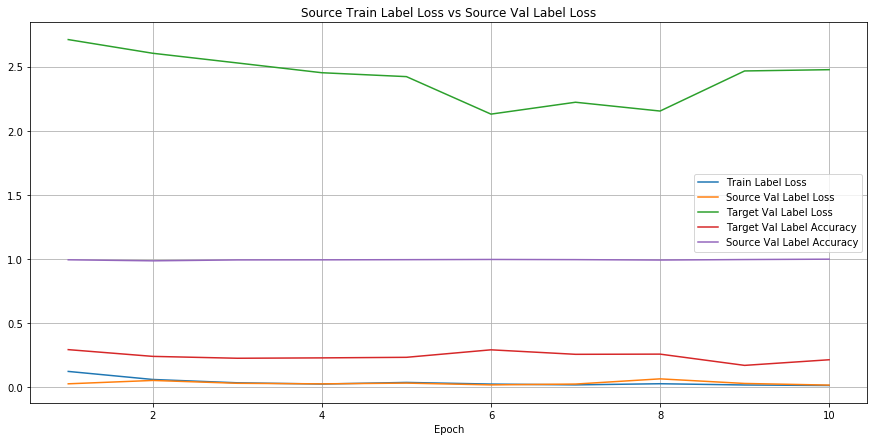

In [25]:
ax = get_loss_curve(experiment)
plt.show()

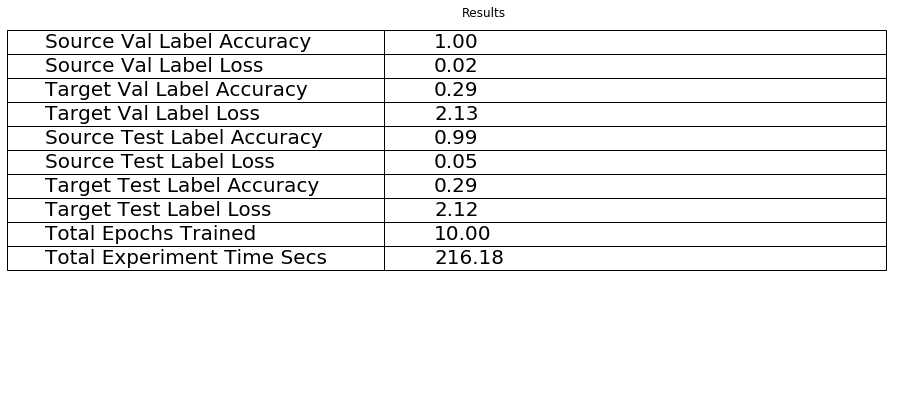

In [26]:
get_results_table(experiment)

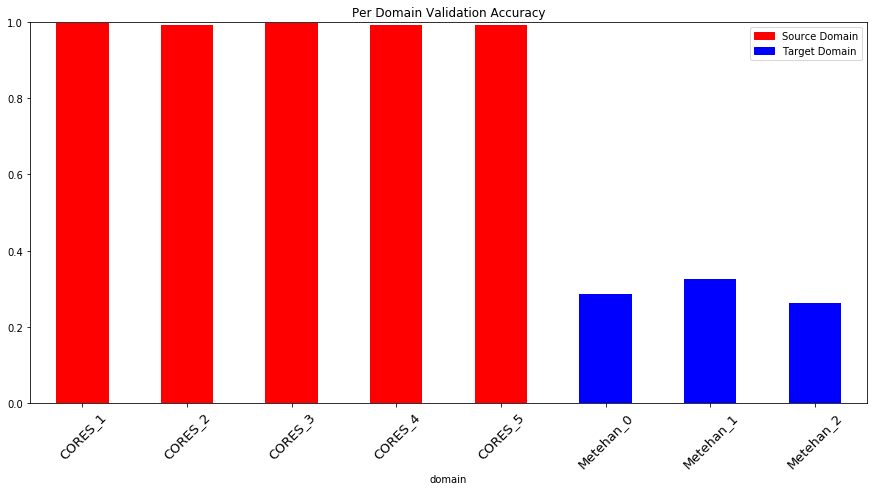

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9929396662387676 Target Test Label Accuracy: 0.29239766081871343
Source Val Label Accuracy: 0.9955070603337612 Target Val Label Accuracy: 0.2909356725146199


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_cores-metehan", "parameters": {"experiment_name": "tl_1_cores-metehan", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 25